# Time Series Analysis

In [101]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as rcParams
import time
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller , acf , pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [20]:
import matplotlib.pyplot as plt

In [26]:
df['Date'] = pd.to_datetime(df['Date'])

In [30]:
index = df.set_index('Date')
df = index['Value']

In [31]:
df

Date
2017-11-09    0.8603
2017-11-08    0.8631
2017-11-07    0.8639
2017-11-06    0.8631
2017-11-03    0.8608
               ...  
1975-01-08    0.7554
1975-01-07    0.7510
1975-01-06    0.7524
1975-01-03    0.7585
1975-01-02    0.7633
Name: Value, Length: 10837, dtype: float64

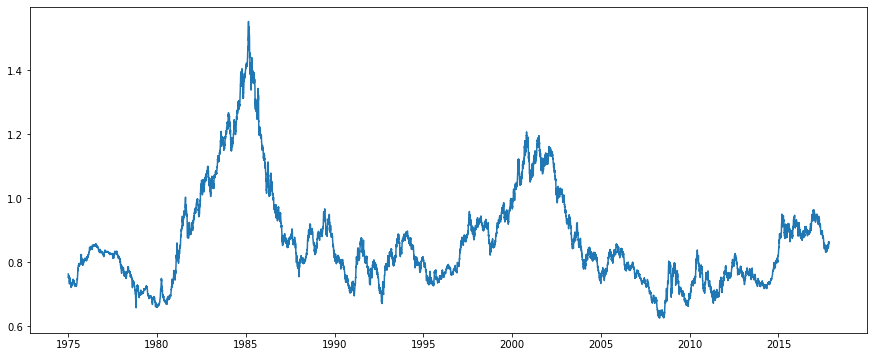

In [37]:
plt.figure(figsize= (15,6))
plt.plot(df)

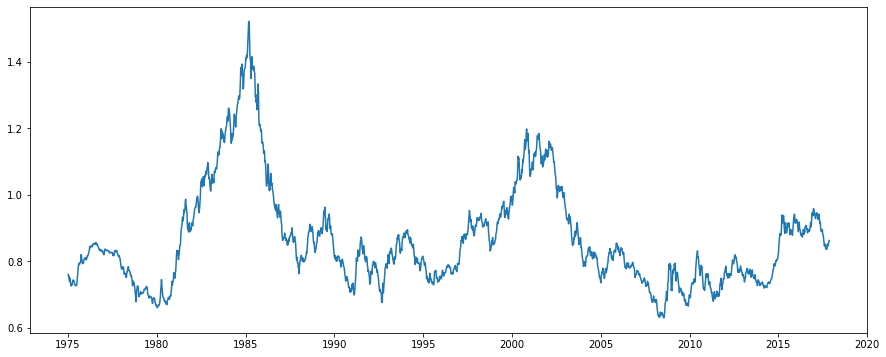

In [46]:
# Resample the data
plt.figure(figsize = (15,6))
df_week = df.resample('W').mean()
plt.plot(df_week)

# Stationarity Check using Dickey Fuller Test

In [98]:
def time_series(timeseries):
    # Find the rolling mean.
    timeseries_mean = timeseries.rolling(window = 52, center = False).mean()
    timeseries_std = timeseries.rolling(window = 52 , center = False).std()
    plt.figure(figsize = (20,10))
    plt.plot(timeseries , color = 'blue',label = 'original')
    plt.plot(timeseries_mean,color = 'red',label =  'Mean')
    plt.plot(timeseries_std , color = 'black',label = 'Std')
    plt.legend(loc = 'best')
    # Now test the adfuller test
    adtest = adfuller(timeseries , autolag = 'AIC')
    adout = pd.Series(adtest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for i , j in adtest[4].items():
        adout['Critical Value %s'% i] = j
    print(adout)

Test Statistic                    -2.054793
p-value                            0.263077
#Lags Used                        21.000000
Number of Observations Used    10815.000000
Critical Value 1%                 -3.430955
Critical Value 5%                 -2.861807
Critical Value 10%                -2.566912
dtype: float64


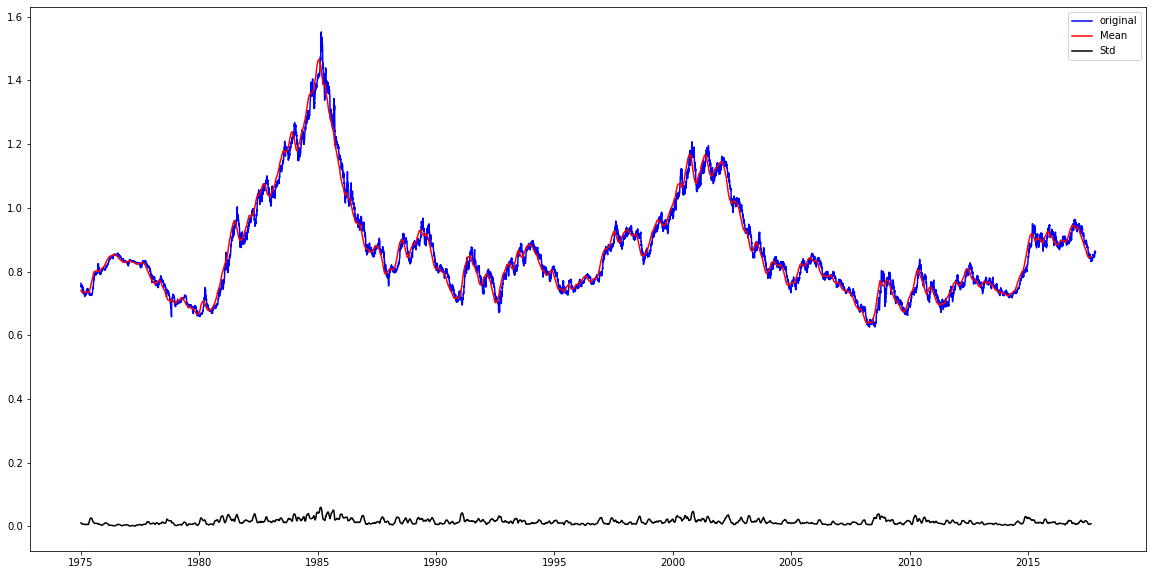

In [99]:
time_series(df)
    

# Convert Data into stationary data

In [104]:
df_week_log = np.log(df_week)
df_week_log_diff = df_week_log - df_week_log.shift()

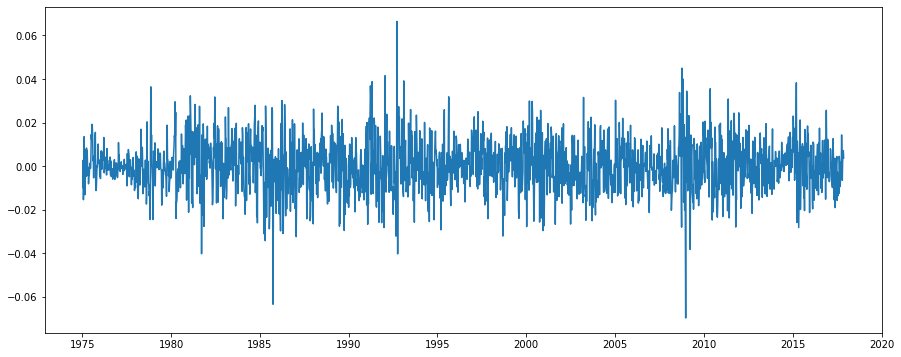

In [106]:
plt.plot(df_week_log_diff)

# Dickey Fuller test on Transformed data

In [107]:
df_week_log_diff.dropna(inplace = True)

Test Statistic                  -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value 1%                -3.433279
Critical Value 5%                -2.862834
Critical Value 10%               -2.567459
dtype: float64


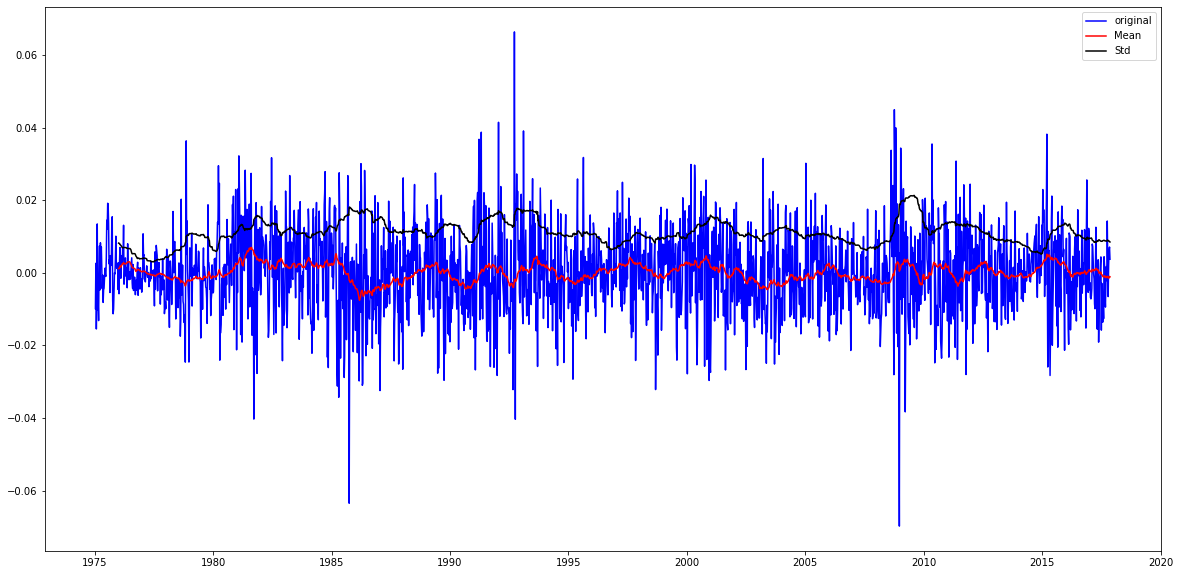

In [108]:
time_series(df_week_log_diff)

# Identify the ACF and PACF data

In [110]:
lag_acf = acf(df_week_log_diff , nlags = 10)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [112]:
lag_pacf = pacf(df_week_log , nlags = 10)

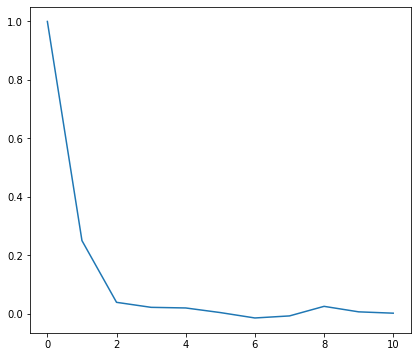

In [114]:
plt.subplot(122)
plt.plot(lag_acf)


# Arima MODEL Implementation

In [118]:
# Now we use the 
model = ARIMA(df_week_log , order = (2,1,1))
arima_result = model.fit()

Text(0.5, 1.0, 'RSS: 0.2806')

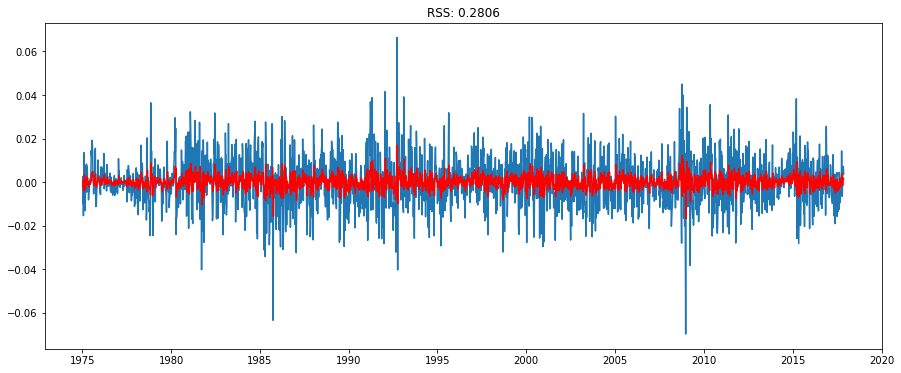

In [121]:
plt.plot(df_week_log_diff)
plt.plot(arima_result.fittedvalues , color = 'red')
plt.title('RSS: %.4f'% sum((arima_result.fittedvalues-df_week_log_diff)**2))

In [122]:
print(arima_result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Tue, 02 Jun 2020   AIC                         -13731.202
Time:                        13:47:41   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

,0
count,2236.000000
mean,0.000001
std,0.011205
min,-0.061306
25%,-0.006725
50%,-0.000228
75%,0.006869
max,0.064140


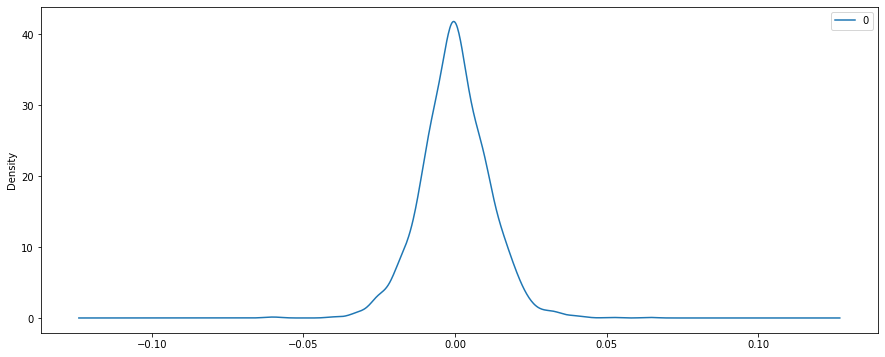

In [127]:
#Plot the residuals
residual = pd.DataFrame(arima_result.resid)
residual.plot(kind = 'kde')
residual.describe()

# Future prediction using ARIMA Model

In [131]:
predicted_arima = pd.Series(arima_result.fittedvalues, copy = True)
print(predicted_arima.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


Text(0.5, 1.0, 'RMSE: inf')

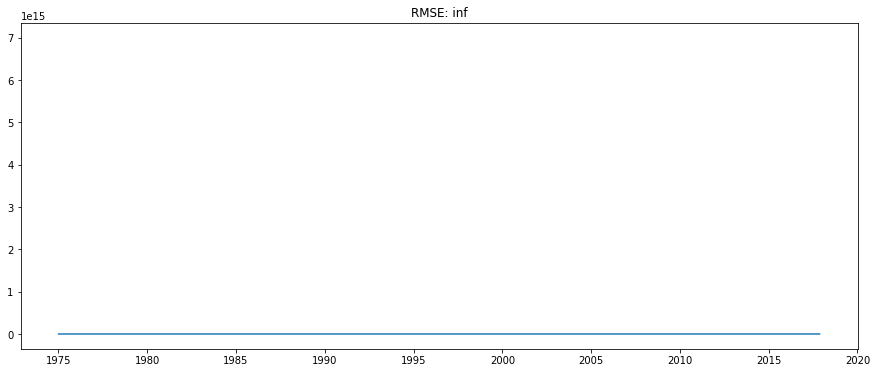

In [141]:
predicted_arima_cumsum = predicted_arima.cumsum()
predicted_arima_log = pd.Series(df_week_log.ix[0], index = df_week_log.index)
predicted_arima_log = predicted_arima_log.add(predicted_arima_cumsum,fill_value = 0)
predicted_arima = np.exp(predicted_arima_log)
plt.plot(df_week)
plt.plot(predicted_arima)
plt.title('RMSE: %.4f'% np.sqrt(sum((predicted_arima-df_week)**2)/len(df_week)))

In [142]:
size = int(len(df_week_log) - 15)
train, test = df_week_log[0:size], df_week_log[size:len(df_week_log)]
history = [x for x in train]
predictions = list()

In [144]:
size = int(len(df_week_log) - 15)
train, test = df_week_log[0:size], df_week_log[size:len(df_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...


predicted=0.860853, expected=0.862600


In [145]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.000043


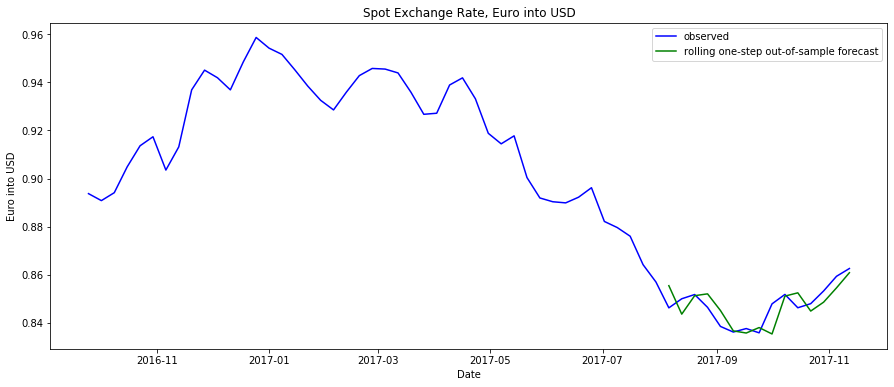

In [148]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(df_week[-60:], 'b', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper right')
legend.get_frame().set_facecolor('w')